# Time Coverage

In [1]:
# Set root folder
import sys
import os

cwd = os.getcwd()
folder = os.path.basename(cwd)
cwd = os.path.dirname(cwd)
folder = os.path.basename(cwd)
ROOT = os.path.join(cwd)

sys.path.append(ROOT)

import numpy as np
from core.population import Archive
from environments.environments import *
from parameters import params
import pickle as pkl
import analysis.utils as utils
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as grid_spec
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from scipy.stats.mstats import gmean


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
font = {'size'   : 26}

plt.rc('font', **font)
%matplotlib inline

Root directory /home/giuseppe/src/cmans


In [2]:
env_type = 'CB'

if env_type == 'RW':
    env = 'Walker2D'
elif env_type == 'Dummy':
    env = 'Dummy'
elif env_type == 'CB':
    env = 'CollectBall'
elif env_type == 'AM':
    env = 'AntMaze'
elif env_type == 'arm':
    env = 'NDofArm'
elif env_type == 'maze':
    env = 'HardMaze'
elif env_type == 'cur':
    env = 'Curling'
elif env_type == 'cd':
    env = 'CurlingDense'

else:
    raise ValueError('Wrong environment type given: {}'.format(env_type))

# EXP_ROOT = '/mnt/7e0bad1b-406b-4582-b7a1-84327ae60fc4/cmans/'
    
exp_path = os.path.join(ROOT, 'experiment_data')
# exp_path = EXP_ROOT

exp_set_1 = ['SIGN_sign5','TIME-SIGN_sign5', 'NS_1ts', 'NS_all_gen', 'NS_5ts']

exp_set_2 = ['SIGN_sign5', 'TIME-SIGN_sign5', 'NS_5ts', 'SIGN_sign2','TIME-SIGN_sign2']

exp_types = exp_set_1
paths = []

save_path = os.path.join(exp_path, "{}".format(env))

avail_exps = []
for exp_type in exp_types:
    path = os.path.join(exp_path, "{}/{}_{}".format(env, env, exp_type))

    if not os.path.exists(path):
        path = None
        print("No {} experiment for {} env.".format(exp_type, env))
        continue
    paths.append(path)
    avail_exps.append(exp_type)
        
exp_types = avail_exps
max_len = registered_envs[env]['max_steps']

No NS_all_gen experiment for CollectBall env.


## Load Time CVG data

In [3]:
def load_data(path):
    data_path = os.path.join(path)
    if os.path.exists(data_path):
        try:
            with open(data_path, 'rb') as file:
                rd = pkl.load(file)
        except Exception as e:
            print('Error on {}'.format(data_path))
            raise
    else:
        print("{} does not exists.".format(data_path))
    return rd

In [4]:
cvgs = {}

for exp, path in zip(exp_types, paths):
    
    runs = utils.get_runs_list(path)
    runs_cvg = []
    
    for run in runs:
        if os.path.exists(os.path.join(path, run, 'analyzed_data/time_cvg.pkl')):
            data = load_data(os.path.join(path, run, 'analyzed_data/time_cvg.pkl'))
            runs_cvg.append(data)
            
    cvgs[exp] = np.array(runs_cvg);
    
params.load(os.path.join(path, run, '_params.json'));

Loading parameters...
Done


### Prepare to Plot

In [5]:
# Get Mean
data = {}
for exp in cvgs:
    print(exp)
    gens = list(cvgs[exp][0].keys())[::10]
    gens.append(list(cvgs[exp][0].keys())[-1])
    data[exp] = {}
    for gen in gens:
        data[exp][gen] = []
        for run in cvgs[exp]:
            data[exp][gen].append(run[gen])
        data[exp][gen] = np.mean(data[exp][gen], axis=0)
        time_steps = len(data[exp][gen])
        

SIGN_sign5
TIME-SIGN_sign5
NS_1ts
NS_5ts


In [6]:
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    
    cmap=plt.get_cmap('plasma')
    rgba = cmap(0.5)
    
    for i in range(100):
        z[i,:,:] = cmap(i/100)

    xmin, xmax, ymin, ymax = x.min(), x.max(), 0, 1#y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax], # Change the 0.02 to the max y (1)
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

/home/giuseppe/src/cmans/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


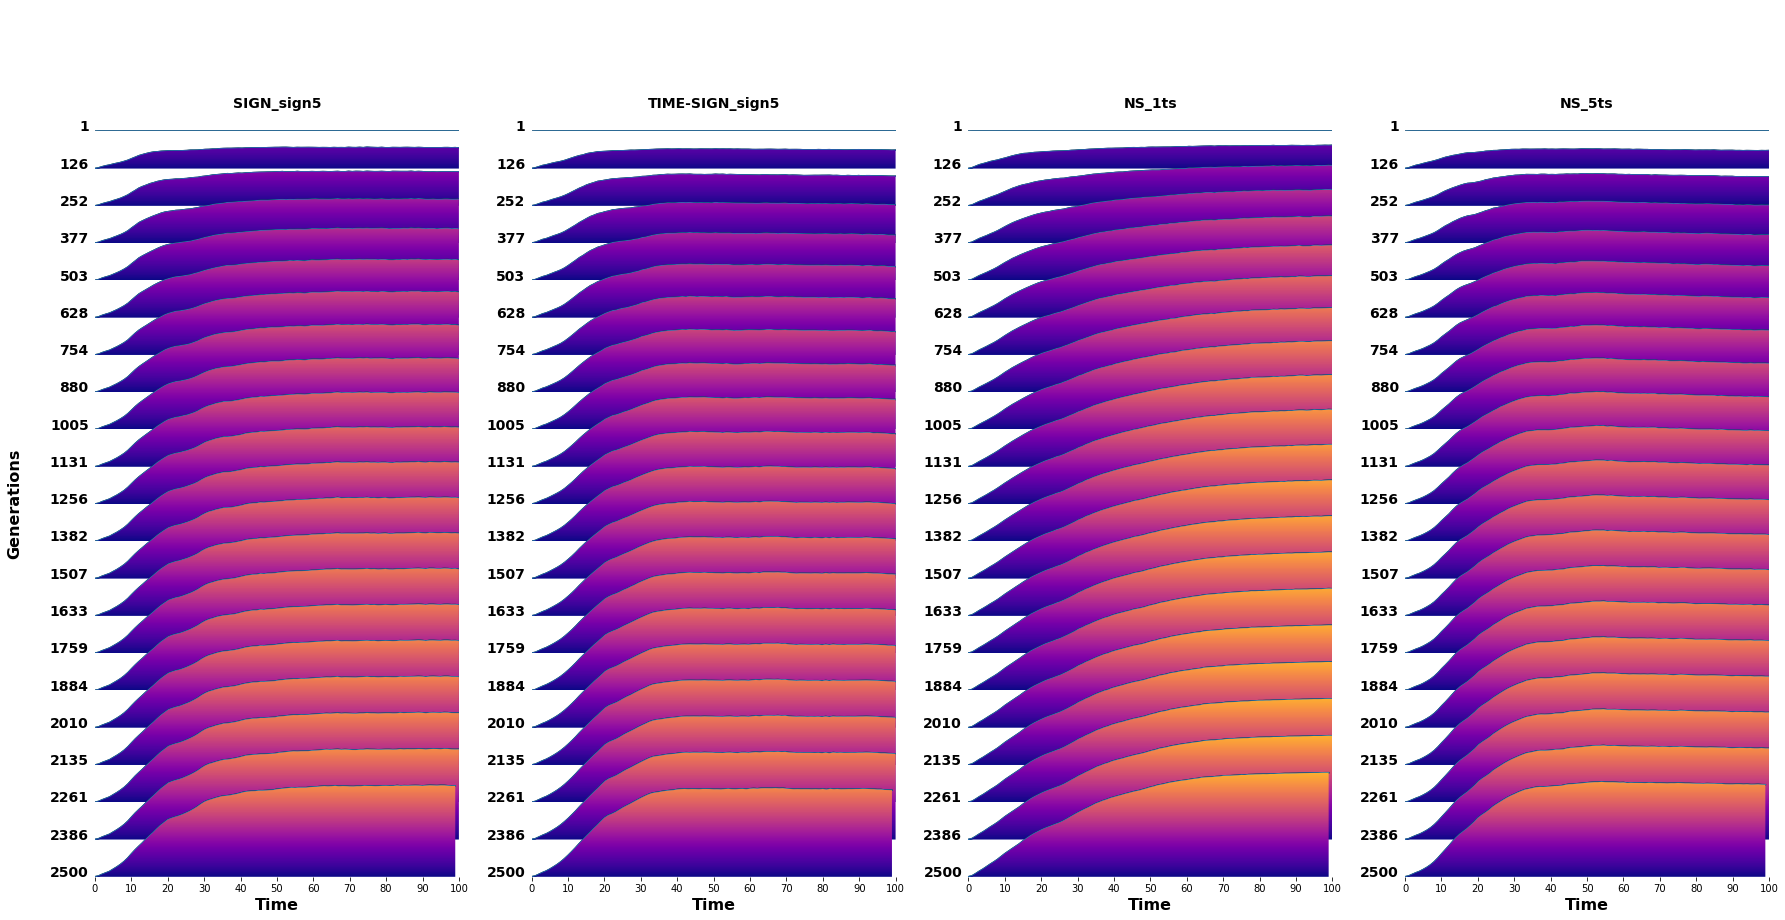

In [7]:
gs = (grid_spec.GridSpec(len(gens),len(cvgs)))

fig = plt.figure(figsize=(30,16))
fig.patch.set_facecolor('white')

i = 0

ax_objs = []

for j, exp in enumerate(cvgs):
    ax_objs.append([])
    for i, gen in enumerate(gens):
        # creating new axes object and appending to ax_objs
        ax_objs[j].append(fig.add_subplot(gs[i:i+1, j:j+1]))

        # plotting the distribution
        ax_objs[j][-1].plot(data[exp][gen], c='black')
        gradient_fill(np.array(range(len(data[exp][gen]))), data[exp][gen], ax=ax_objs[j][-1])
        
        ax_objs[j][-1].set_ylim(0, 1)

        rect = ax_objs[j][-1].patch
        rect.set_alpha(0)
    
        ax_objs[j][-1].set_yticklabels([])
        ax_objs[j][-1].set_ylabel('')
        ax_objs[j][-1].get_yaxis().set_ticks([])

        if i == len(gens):
            pass
        else:
            ax_objs[j][-1].set_xticklabels([])
            ax_objs[j][-1].get_xaxis().set_ticks([])           

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[j][-1].spines[s].set_visible(False)
        
        ax_objs[j][-1].text(-1.7, 0, gen, fontweight="bold", fontsize=14, ha="right")
        
    name = exp#exp.split('_')[0]
    ax_objs[j][0].set_title(name, fontweight="bold", fontsize=14, y=.3, pad=-14)
    
    ax_objs[j][-1].set_xlabel("Time", fontsize=16,fontweight="bold")
    ax_objs[j][-1].get_xaxis().set_ticks(list(range(time_steps+1))[::10])
    ax_objs[j][-1].set_xticklabels(list(range(time_steps+1))[::10])
    

ax_objs[0][int(len(gens)/2)].set_ylabel('Generations', fontsize=16,fontweight="bold", x=-1)
ax_objs[0][int(len(gens)/2)].yaxis.set_label_coords(-0.2,.0)

gs.update(hspace= -0.7)
plt.tight_layout()
plt.show()

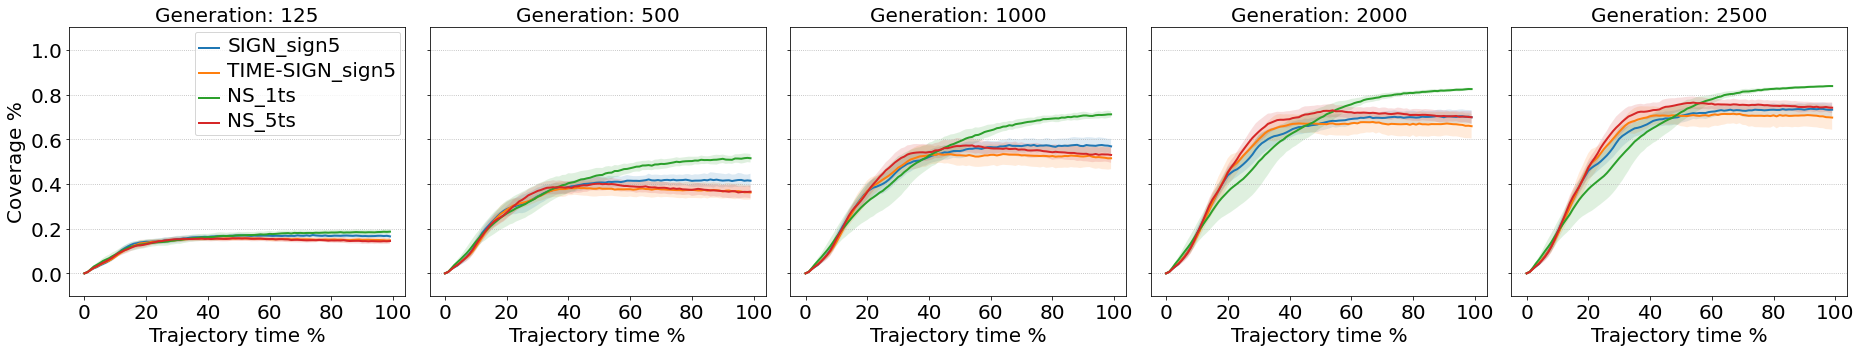

In [8]:
gens = [126, 503, 1005, 2010, 2500]
adj_gens = [125, 500, 1000, 2000, 2500]
fig, axes = plt.subplots(1,len(gens), figsize=(5*len(gens)+1, 5))
selected_data = {}
x_points = np.array(range(0,100))
for j, gen, ag in zip(range(len(gens)), gens, adj_gens):
    gen_sel_data = {}
    for exp in cvgs:
        
        data = [cvgs[exp][i][gen] for i in range(len(cvgs[exp]))]
        mean = np.mean(data, axis=0)
        
        gen_sel_data[exp] = np.array(data)[:, -1]

        std = np.std(data, axis=0)
    
        axes[j].plot(x_points, mean, label=exp, linewidth=2)
        axes[j].fill_between(x_points, mean-std, mean+std, alpha=0.15)
        
        axes[j].set_ylim(-.1, 1.1)

        if j == 0:
            axes[j].set_ylabel('Coverage %')
        else:
            axes[j].set_yticklabels([])
            axes[j].set_ylabel('')
#             axes[j].get_yaxis().set_ticks([])

        axes[j].set_xlabel('Trajectory time %')
        axes[j].grid(True, 'major', 'y', linestyle=':')
    
    selected_data[gen] = gen_sel_data
    axes[j].set_title('Generation: {}'.format(ag))
    
    for item in ([axes[j].title, axes[j].xaxis.label, axes[j].yaxis.label] +
             axes[j].get_xticklabels() + axes[j].get_yticklabels()):
        item.set_fontsize(20)
    
axes[0].legend(loc="upper left")
for item in axes[0].legend().get_texts():
    item.set_fontsize(20)

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'time_cvg.pdf'), format='pdf')

plt.show()

In [9]:
from scipy.stats import ttest_ind
import itertools

for gen in selected_data:
    print("GEN: {}".format(gen))
    exps = list(selected_data[gen].keys())
    
    exps = list(itertools.combinations(exps, 2))
    for exp in exps:
        res = ttest_ind(selected_data[gen][exp[0]], selected_data[gen][exp[1]])
        print("EXPS: {} - VALUES: {}".format(exp, res.pvalue))

GEN: 126
EXPS: ('SIGN_sign5', 'TIME-SIGN_sign5') - VALUES: 0.00010877712750778842
EXPS: ('SIGN_sign5', 'NS_1ts') - VALUES: 1.0199305873691252e-05
EXPS: ('SIGN_sign5', 'NS_5ts') - VALUES: 3.081044821466302e-05
EXPS: ('TIME-SIGN_sign5', 'NS_1ts') - VALUES: 4.913175540401514e-11
EXPS: ('TIME-SIGN_sign5', 'NS_5ts') - VALUES: 0.43371948459781673
EXPS: ('NS_1ts', 'NS_5ts') - VALUES: 3.9330563918368845e-11
GEN: 503
EXPS: ('SIGN_sign5', 'TIME-SIGN_sign5') - VALUES: 0.00011775039622404879
EXPS: ('SIGN_sign5', 'NS_1ts') - VALUES: 1.8996248320583942e-11
EXPS: ('SIGN_sign5', 'NS_5ts') - VALUES: 0.00018124146894317662
EXPS: ('TIME-SIGN_sign5', 'NS_1ts') - VALUES: 5.472178389589458e-16
EXPS: ('TIME-SIGN_sign5', 'NS_5ts') - VALUES: 0.7560084270323789
EXPS: ('NS_1ts', 'NS_5ts') - VALUES: 2.7698428809716024e-16
GEN: 1005
EXPS: ('SIGN_sign5', 'TIME-SIGN_sign5') - VALUES: 0.002240538062991623
EXPS: ('SIGN_sign5', 'NS_1ts') - VALUES: 2.698335583278857e-15
EXPS: ('SIGN_sign5', 'NS_5ts') - VALUES: 0.0063378